# Cats and Dogs Classifier:


1.   Setup fastai
2.   Make a DataBunch
3.   Make Learner
4.   Train a Model
5.   Check The Results
6.   Unfreezing our data, fine-tuning, and our learning rates



### 1- Setup fastai

In [1]:
#Run once per session
!pip install fastai -q --upgrade

Now we are going to use three different libraries inside fastai that help us with this task


1.   `basics` -> helps us with some basics functions
2.   `callback` -> helps us to access to various fit functions
3.   `vision` -> tells us that we are going to do a vision task






In [2]:
# Import these three libraries
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

### 2- Make a DataBunch

*   Download the dataset
*   Build a `DataLoaders`
*   Basic transforms
*   Build `ImageDataLoaders`





#### Download the dataset
We'll be trying to identify between 12 species of cats and 25 species of dogs (37 in total).

In [3]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url: 'str', archive: 'Path' = None, data: 'Path' = None, c_key: 'str' = 'data', force_download: 'bool' = False, base: 'str' = '~/.fastai') -> 'Path'
    Download `url` using `FastDownload.get`



`untar_data` is a thin wrapper for `FastDownload.get`. It downloads and extracts url, by default to subdirectories of `~/.fastai`, and returns the path to the extracted data

In [5]:
# Download the data that we need for this problem
path = untar_data(URLs.PETS)

In [6]:
# Set our seed
np.random.seed(2)

In [7]:
path.ls()[:3]

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

#### Build a `DataLoaders`.
They help you to investigate, clean, change and prepare your data before, during and after building your deep learning model.

In [8]:
# path that our images stored inside it
path = untar_data(URLs.PETS)
# grap all of our images (our inputs)
fnames = get_image_files(path/'images')
# extract our class names  (our outputs)
pat = r'(.+)_\d+.jpg$'

#### Basic transforms

In [9]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

#### Build `ImageDataLoaders` - highest level API

In [10]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

Let's rebuild using the DataBlock api - Medium Level

In [11]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [12]:
path_im = path/'images'

In [13]:
dls = pets.dataloaders(path_im, bs=bs)

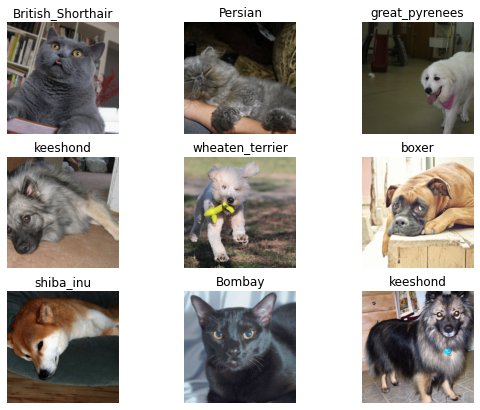

In [15]:
# Take a look at a batch of our images
dls.show_batch(max_n=9, figsize=(9,7))

If we want to see the names of our classes we have, we can simply call `dls.vocab`

In [16]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [17]:
# to grab the Class2Index mapping.
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

fastai.data.transforms.CategoryMap

#### 3- Make Learner
We will be using a convolutional neural network backbone and a fully connected head with a single hidden layer as our classifier. 

First, we need to make our Neural Network and our `Learner` like before. 

A `Learner` needs (on a base level):

* `DataLoaders`
* Some architecture
* A evaluation metric
* A loss function
* An optimizer

We'll also use `mixed_precision` (`fp16`)

In [19]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pt

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

##### Note 
We don't declare our loss function, So some assumptions being made here:

* Loss function is assumed as classification, so `CrossEntropyFlat`
* Optimizer is assumed to be Adam

#### 4- Train Our Model
We will train it for four cycles through all our data

In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.952512,0.379291,0.128552,01:12
1,0.686932,0.269028,0.086604,01:08
2,0.373439,0.240210,0.073748,01:07
3,0.289245,0.236274,0.074425,01:06


In [21]:
learn.save('stage_1')

Path('models/stage_1.pth')

#### 5- Check The Results

let's look at where our it might've messed up. What species did it have trouble differentiating between?

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

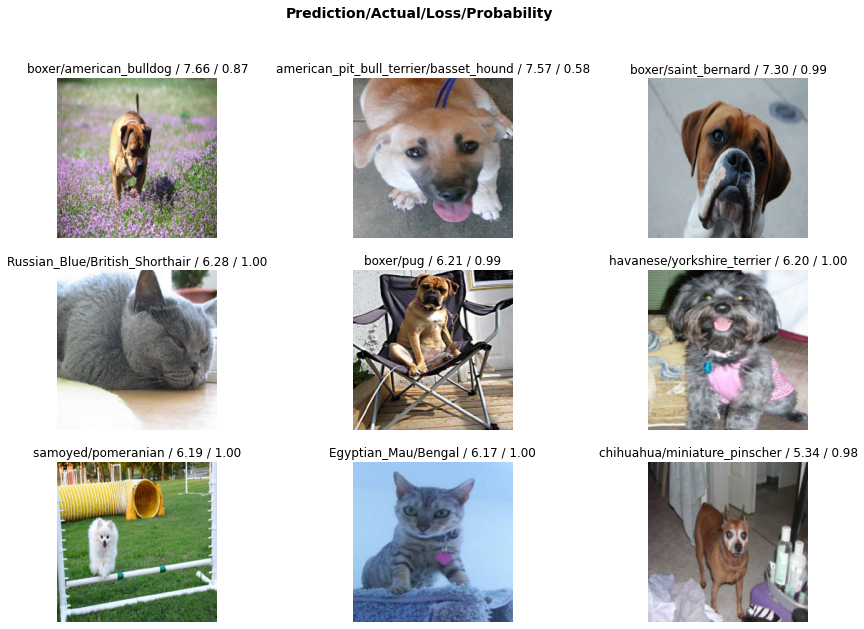

In [23]:
interp.plot_top_losses(9, figsize=(15,10))

`plot_confusion_matrix` just needs a figure size. dpi adjusts the quality

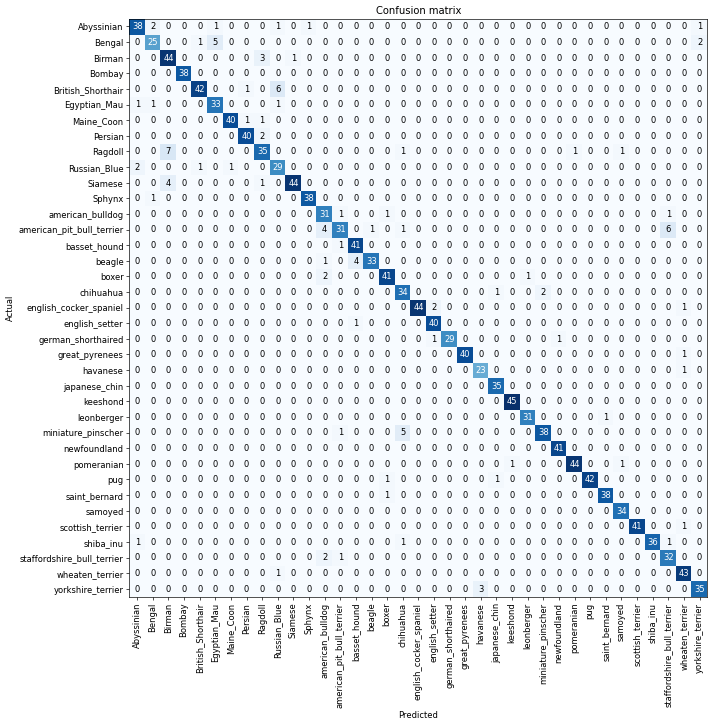

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
# grab our most confused
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 7),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('miniature_pinscher', 'chihuahua', 5),
 ('Siamese', 'Birman', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('beagle', 'basset_hound', 4),
 ('Birman', 'Ragdoll', 3),
 ('yorkshire_terrier', 'havanese', 3)]

#### 6- Unfreezing our data, fine-tuning, and our learning rates

So, we have the model. Let's fine tune it. First, we need to load our model back in.

In [26]:
learn.load('stage_1');

In [27]:
# unfreeze it
learn.unfreeze()

In [28]:
# Train it
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.151437,3.252560,0.636671,01:08
1,1.090042,1.432293,0.367388,01:09
2,0.587026,0.511665,0.162382,01:07
3,0.314229,0.382614,0.121110,01:07


Now when we unfreeze, we unfreeze all the layers. So to show how a difference of a proper learning rate looks, let's load in those old weights and try using `lr_find()`

In [29]:
learn.load('stage_1');

SuggestedLRs(valley=4.365158383734524e-05)

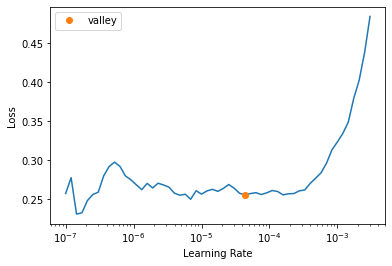

In [30]:
learn.lr_find()

In [31]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.246783,0.219696,0.073748,01:09
1,0.233876,0.227946,0.072395,01:07
2,0.168598,0.196751,0.060217,01:07
3,0.135176,0.202937,0.062923,01:07


In [32]:
learn.save('stage_2')

Path('models/stage_2.pth')